# データセット
- 1,854クラス，22,448枚の画像
- 各クラスについて、train:val:test=6:2:2で分割
- 4人の被験者
- 合計 22,448*4=89792
- train:val:test=53875.2:17958.4:17958.4 のはずだが
- train:val:test=65728:16432:16432 になっている

## 前処理：data preprocessing and cleaning
1. バンドパスフィルタ
    - 0.1 Hzから40 Hzの範囲でバンドパスフィルタを適用
    - 目的：低周波数のドリフトや高周波数のノイズが除去され、脳の主要な活動周波数帯域を強調する
2. 信号ドロップアウトの処理
    - 200ms未満でMEG信号が途切れたデータのセグメントを、エポック化前の中央値のセンサー応答で置き換える
    - 効果：欠落したデータが分析に与える影響を最小限に抑える
3. 試行開始のマーク付け
    - 光学センサーを用いて、刺激の開始を検出し、連続したMEG記録のエポックをマークした
    - 効果：時間遅延を考慮した正確なタイミングでのデータセグメントの抽出が可能になる
4. データのエポック化
    - 連続したデータを刺激開始の-100msから1300msまでの範囲にエポック化する
5. ベースライン補正
    - エポック化したデータを、刺激開始前の100ms間の平均を引き、標準偏差で割ることでベースライン補正を行う
    - 目的：各試行のデータが同じ基準で比較され、より安定した解析が可能になる
6. ノイズの多いセンサーの除外
    - 全ての被験者に対して、定期的にロックが解除され非常にノイズの多いセンサー（MRO11）を除外する
7. ダウンサンプリング
    - データを200 Hzにダウンサンプリングする
    - 目的：計算負荷を軽減し、後続の解析が効率的に行えるようにする


## 処理後のデータ
- 形状：(num_channels, seq_len) = (271, 281)
- num_channels:
    - 271の有効なMEGセンサーから取得された信号
- seq_len:
    - 各エポックのシーケンス長は281サンプル
    - ダウンサンプリング後のサンプリングレートが200Hzであるため、1秒間に200サンプルが得られる
    - 刺激の前100msと後1300msをカバーするエポックの合計時間は1400ms
    - 200*1.4=280
    - 最終的に281サンプル（オフバイワンエラーを含む可能性）に丸められている

In [17]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from scipy import signal

In [3]:
data_dir= '../data/'

train_X_path = data_dir + 'train_X.pt'
train_subject_path = data_dir + 'train_subject_idxs.pt'
train_y_path = data_dir + 'train_y.pt'

val_X_path = data_dir + 'val_X.pt'
val_subject_path = data_dir + 'val_subject_idxs.pt'
val_y_path = data_dir + 'val_y.pt'

test_X_path = data_dir + 'test_X.pt'
test_subject_path = data_dir + 'test_subject_idxs.pt'

# データを読み込む
train_X = torch.load(train_X_path)
train_subject = torch.load(train_subject_path)
train_y = torch.load(train_y_path)

val_X = torch.load(val_X_path)
val_subject = torch.load(val_subject_path)
val_y = torch.load(val_y_path)

test_X = torch.load(test_X_path)
test_subject = torch.load(test_subject_path)

In [4]:
# データを確認する
print('----- train -----')
print(type(train_X), train_X.shape)
print(type(train_subject), train_subject.shape)
print(type(train_y), train_y.shape)

print('----- val -----')
print(type(val_X), val_X.shape)
print(type(val_subject), val_subject.shape)
print(type(val_y), val_y.shape)

print('----- test -----')
print(type(test_X), test_X.shape)
print(type(test_subject), test_subject.shape)

----- train -----
<class 'torch.Tensor'> torch.Size([65728, 271, 281])
<class 'torch.Tensor'> torch.Size([65728])
<class 'torch.Tensor'> torch.Size([65728])
----- val -----
<class 'torch.Tensor'> torch.Size([16432, 271, 281])
<class 'torch.Tensor'> torch.Size([16432])
<class 'torch.Tensor'> torch.Size([16432])
----- test -----
<class 'torch.Tensor'> torch.Size([16432, 271, 281])
<class 'torch.Tensor'> torch.Size([16432])


In [5]:
print(train_X[0].shape)
print(train_X[0])

torch.Size([271, 281])
tensor([[ 1.5771,  0.5370,  0.1519,  ...,  0.1662, -0.3599, -1.6788],
        [ 1.9468,  1.6864,  1.3518,  ..., -1.3328, -1.5306, -2.2897],
        [ 1.2937,  1.3062,  1.1686,  ..., -1.0367, -0.8830, -1.1998],
        ...,
        [-0.3281, -0.8782, -1.1338,  ...,  0.3077,  0.2089,  0.1742],
        [-1.1487, -1.4622, -1.6628,  ...,  0.1894, -0.0746, -0.1722],
        [ 1.3936,  0.7902,  0.1187,  ...,  0.4114,  0.7303,  1.4094]])


In [6]:
print(train_subject[0])
# train_subjectの値ごとのデータ数を確認
print(np.unique(train_subject, return_counts=True))

tensor(0)
(array([0, 1, 2, 3]), array([16432, 16432, 16432, 16432]))


In [7]:
print(train_y[0])
# train_yの値ごとのデータ数を確認
print(np.unique(train_y, return_counts=True))

tensor(1759)
(array([   0,    1,    2, ..., 1851, 1852, 1853]), array([32, 32, 32, ..., 32, 32, 32]))


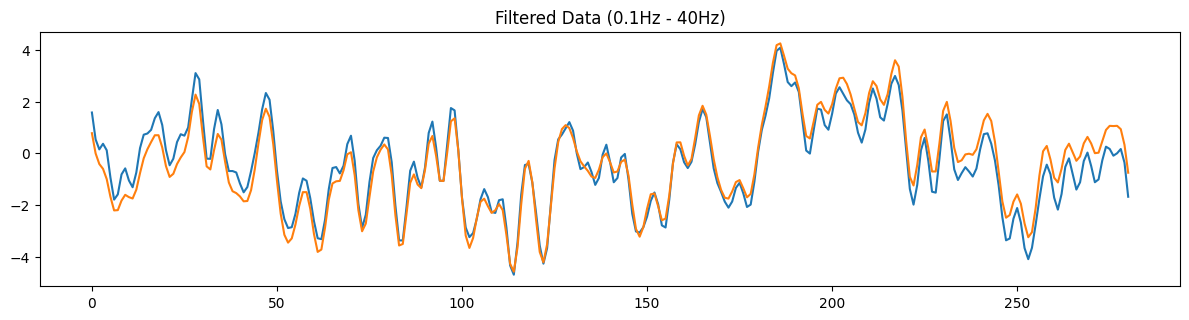

In [19]:
# データの取得
data = train_X[0][0]

# フィルタの設計
fs = 200  # サンプリングレート（仮の値）
lowcut = 0.1
highcut = 40.0

nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq
b, a = signal.butter(5, [low, high], btype='band')

# フィルタの適用
filtered_data = signal.filtfilt(b, a, data)

# 結果のプロット
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(data)
plt.title('Original Data')

# plt.subplot(2, 1, 2)
plt.plot(filtered_data)
plt.title('Filtered Data (0.1Hz - 40Hz)')

plt.tight_layout()
plt.show()

In [28]:
# ベースライン補正の適用
# -100ms~1300msのデータのうち、-100ms~0msのデータをベースラインとして補正
print(data[:20].shape, data[:20])
baseline = np.mean(data[:20].numpy())
# 標準偏差
std = np.std(data[:20].numpy())
print(baseline, std)
baseline_corrected_data = (data - baseline) / std

torch.Size([20]) tensor([ 1.5771,  0.5370,  0.1519,  0.3688,  0.1182, -0.9298, -1.7890, -1.5865,
        -0.8149, -0.5817, -1.0494, -1.3107, -0.7397,  0.2013,  0.7199,  0.7660,
         0.9084,  1.3563,  1.5931,  1.0946])
0.029538536 1.0350901
